# VGG Model for Face Recognition

In [52]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import re
import nbformat
import shutil
import random


from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image, ImageEnhance, ImageFilter

import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [5]:
IMAGE_SIZE = [224, 224]
train_path = './MEG_face_stim/train/'
test_path = './MEG_face_stim/test/'
augtrainsplit_dir = './MEG_face_stim/augtrainsplit/'
augtestsplit_dir = './MEG_face_stim/augtestsplit/'
data_dir = './MEG_face_stim/'

Working with 4 images


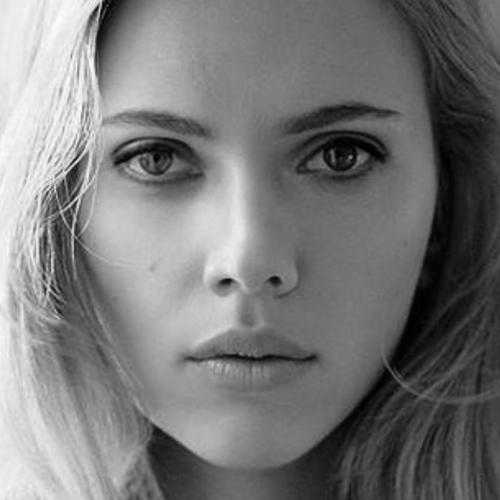

In [6]:
n = 6
files = [f for f in os.listdir(train_path + str(n)) if os.path.isfile(os.path.join(train_path + str(n), f))]
print(f"Working with {len(files)} images")

i = 3
display(_Imgdis(filename=train_path + str(n) + '/' + files[i], width=240, height=240))


# Augment Images

In [7]:
augtrain_dir = './MEG_face_stim/augtrain/'
augtest_dir = './MEG_face_stim/augtest/'
augall_dir = './MEG_face_stim/augall/'
exptrain_dir = './MEG_face_stim/exptrain/'
exptest_dir = './MEG_face_stim/exptest/'
augtrainsplit_dir = './MEG_face_stim/augtrainsplit/'
augtestsplit_dir = './MEG_face_stim/augtestsplit/'

for i in range(1, 17):
    os.makedirs(os.path.join(augtrain_dir, str(i)), exist_ok=True)
    os.makedirs(os.path.join(augtest_dir, str(i)), exist_ok=True)
    os.makedirs(os.path.join(augall_dir, str(i)), exist_ok=True)
    os.makedirs(os.path.join(exptrain_dir, str(i)), exist_ok=True)
    os.makedirs(os.path.join(exptest_dir, str(i)), exist_ok=True)

In [ ]:
def aug_rotate(input_dir, output_dir, angles):
    for subdir in os.listdir(input_dir):
        src_dir = os.path.join(input_dir, subdir)
        dest_dir = os.path.join(output_dir, subdir)

        print(src_dir)


        for img_file in os.listdir(src_dir):
            print("hello")
            if not img_file.endswith('.jpg'):
                continue


            img_path = os.path.join(src_dir, img_file)
            img = Image.open(img_path)

            for angle in angles:
                rotated_img = img.rotate(angle)
                rotated_img_path = os.path.join(dest_dir, img_file[:-4] + '_rotate_' + str(angle) + '.jpg')
                rotated_img.save(rotated_img_path)
                


# Define the augmentation functions
def aug_brightness(input_dir, output_dir, factors):
    for subdir in os.listdir(input_dir):
        src_dir = os.path.join(input_dir, subdir)
        dest_dir = os.path.join(output_dir, subdir)


        for img_file in os.listdir(src_dir):
            if not img_file.endswith('.jpg'):
                continue

            img_path = os.path.join(src_dir, img_file)
            img = Image.open(img_path)

            for factor in factors:
                enhancer = ImageEnhance.Brightness(img)
                bright_img = enhancer.enhance(factor)
                bright_img_path = os.path.join(dest_dir, img_file[:-4] + '_bright_' + str(factor) + '.jpg')
                bright_img.save(bright_img_path)


def aug_noise(input_dir, output_dir, factors):
    for subdir in os.listdir(input_dir):
        src_dir = os.path.join(input_dir, subdir)
        dest_dir = os.path.join(output_dir, subdir)

        for img_file in os.listdir(src_dir):
            if not img_file.endswith('.jpg'):
                continue

            img_path = os.path.join(src_dir, img_file)
            img = Image.open(img_path)

            for factor in factors:
                noise_img = img.filter(ImageFilter.GaussianBlur(radius=factor))
                noise_img_path = os.path.join(dest_dir, img_file[:-4] + '_noise_' + str(factor) + '.jpg')
                noise_img.save(noise_img_path)


def aug_horizontal_shift(input_dir, output_dir, shift_range):
    for subdir in os.listdir(input_dir):
        src_dir = os.path.join(input_dir, subdir)
        dest_dir = os.path.join(output_dir, subdir)

        for img_file in os.listdir(src_dir):
            if not img_file.endswith('.jpg'):
                continue

            img_path = os.path.join(src_dir, img_file)
            img = Image.open(img_path)

            for shift in shift_range:
                x_shift = int(shift * img.width)
                shifted_img = img.transform((img.width, img.height), Image.AFFINE, (1, 0, x_shift, 0, 1, 0))
                shifted_img_path = os.path.join(dest_dir, img_file[:-4] + '_hshift_' + str(shift) + '.jpg')
                shifted_img.save(shifted_img_path)


def aug_vertical_shift(input_dir, output_dir, shift_range):
    for subdir in os.listdir(input_dir):
        src_dir = os.path.join(input_dir, subdir)
        dest_dir = os.path.join(output_dir, subdir)

        for img_file in os.listdir(src_dir):
            if not img_file.endswith('.jpg'):
                continue

            img_path = os.path.join(src_dir, img_file)
            img = Image.open(img_path)

            for shift in shift_range:
                y_shift = int(shift * img.height)
                shifted_img = img.transform((img.width, img.height), Image.AFFINE, (1, 0, 0, 0, 1, y_shift))
                shifted_img_path = os.path.join(dest_dir, img_file[:-4] + '_vshift_' + str(shift) + '.jpg')
                shifted_img.save(shifted_img_path)


In [ ]:
aug_rotate(train_path, augtrain_dir, [10, 20, 30, -10, -20, -30])
aug_brightness(train_path, augtrain_dir, [0.5, 0.75, 1.25, 1.5])
aug_noise(train_path, augtrain_dir, [0.5, 1, 3, 5])
aug_horizontal_shift(train_path, augtrain_dir, [-0.25, -0.125, 0.125, 0.25])
aug_vertical_shift(train_path, augtrain_dir, [-0.25, -0.125, 0.125, 0.25])

In [ ]:
print("Rotation")
aug_rotate(test_path, augtest_dir, [10, 20, 30, -10, -20, -30])
print("Brightness")
aug_brightness(test_path, augtest_dir, [0.5, 0.75, 1.25, 1.5])
print("Noise")
aug_noise(test_path, augtest_dir, [0.5, 1, 3, 5])
print("Horizontal")
aug_horizontal_shift(test_path, augtest_dir, [-0.25, -0.125, 0.125, 0.25])
print("Vertical")
aug_vertical_shift(test_path, augtest_dir, [-0.25, -0.125, 0.125, 0.25])

In [ ]:
# combine augtest and augtrain in augall
if not os.path.exists(augall_dir):
    os.mkdir(augall_dir)

for subdir in os.listdir(augtrain_dir):
    src_dir = os.path.join(augtrain_dir, subdir)
    dest_dir = os.path.join(augall_dir, subdir)

    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)

    for img_file in os.listdir(src_dir):
        src_path = os.path.join(src_dir, img_file)
        dest_path = os.path.join(dest_dir, img_file)
        shutil.copy(src_path, dest_path)

for subdir in os.listdir(augtest_dir):
    src_dir = os.path.join(augtest_dir, subdir)
    dest_dir = os.path.join(augall_dir, subdir)

    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)

    for img_file in os.listdir(src_dir):
        src_path = os.path.join(src_dir, img_file)
        dest_path = os.path.join(dest_dir, img_file)
        shutil.copy(src_path, dest_path)

In [ ]:
# plot all types of augmented images in directory k = 6
aug_dir = f'{augtrainsplit_dir}/6'

# Collect all image files in directory
img_files = [os.path.join(aug_dir, f) for f in os.listdir(aug_dir) if f.endswith('.jpg')]

# figsize
figsize = (8, 8)

# Display specific images by index
print("Brightness")
start = 66
indices = [start, start+1, start+2, start+3]
fig, axs = plt.subplots(ncols=len(indices), figsize=(4*len(indices), 4))
for i, idx in enumerate(indices):
    img_file = img_files[idx]
    img = Image.open(img_file)
    axs[i].imshow(img, cmap='magma')
    axs[i].axis('off')
fig.set_size_inches(figsize)
plt.show()

# Display specific images by index
print("Shift")
start = 70
indices = [start, start+1, start+2, start+3]
fig, axs = plt.subplots(ncols=len(indices), figsize=(4*len(indices), 4))
for i, idx in enumerate(indices):
    img_file = img_files[idx]
    img = Image.open(img_file)
    axs[i].imshow(img, cmap='magma')
    axs[i].axis('off')
fig.set_size_inches(figsize)
plt.show()

# Display specific images by index
print("Noise")
start = 74
indices = [start, start+1, start+2, start+3]
fig, axs = plt.subplots(ncols=len(indices), figsize=(4*len(indices), 4))
for i, idx in enumerate(indices):
    img_file = img_files[idx]
    img = Image.open(img_file)
    axs[i].imshow(img, cmap='magma')
    axs[i].axis('off')
fig.set_size_inches(figsize)
plt.show()


# Display specific images by index
print("Rotate")
start = 78
indices = [start, start+1, start+2, start+3]
fig, axs = plt.subplots(ncols=len(indices), figsize=(4*len(indices), 4))
for i, idx in enumerate(indices):
    img_file = img_files[idx]
    img = Image.open(img_file)
    axs[i].imshow(img, cmap='magma')
    axs[i].axis('off')
fig.set_size_inches(figsize)
plt.show()

In [33]:
def gen_exp_data(srcdir, destdir):
    for N in range(1, 17):
        for file in os.listdir(f'{srcdir}/{N}'):
            img = Image.open(f'{srcdir}/{N}/{file}')

            height = img.height
            line1 = img.height/3 + 35
            line2 = 2*img.height/3 - 30

            top_img = img.crop((0, 0, img.width, line1))
            middle_img = img.crop((0, line1, img.width, line2))
            bottom_img = img.crop((0, line2, img.width, img.height))

            # # blacken the top 20px of the top image
            # top_img = np.array(top_img)
            # top_img[:100, :] = 0
            # top_img = Image.fromarray(top_img)

            # # blacken the bottom 20px of the bottom image
            # bottom_img = np.array(bottom_img)
            # bottom_img[bottom_img.shape[0]-90:, :] = 0
            # bottom_img = Image.fromarray(bottom_img)

            # combine the images in a random order
            final = [bottom_img, middle_img, top_img]
            # random.shuffle(final)
            final = np.concatenate(final, axis=0)
            final = Image.fromarray(final)


            # save the image
            final.save(f'{destdir}/{N}/{file}')

In [34]:
srcdir = os.path.join(data_dir, 'augtrain')
destdir = os.path.join(data_dir, 'exptrain')
gen_exp_data(srcdir, destdir)

In [35]:
srcdir = os.path.join(data_dir, 'augtest')
destdir = os.path.join(data_dir, 'exptest')
gen_exp_data(srcdir, destdir)

# VGG Model

In [8]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

In [9]:
NUM_CLASSES = len(glob(train_path + '/*'))
print(f"Number of classes: {NUM_CLASSES}")
x = Flatten()(vgg.output)
prediction = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Number of classes: 16
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56,

In [10]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_set = gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

test_set = gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

augtrain_set = gen.flow_from_directory(
    augtrain_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

augtest_set = gen.flow_from_directory(
    augtest_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

augtrainsplit_set = gen.flow_from_directory(
    augtrainsplit_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

augtestsplit_set = gen.flow_from_directory(
    augtestsplit_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

exptrain_set = gen.flow_from_directory(
    exptrain_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

exptest_set = gen.flow_from_directory(
    exptest_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 64 images belonging to 16 classes.
Found 16 images belonging to 16 classes.
Found 1408 images belonging to 16 classes.
Found 352 images belonging to 16 classes.
Found 1403 images belonging to 16 classes.
Found 357 images belonging to 16 classes.
Found 1408 images belonging to 16 classes.
Found 352 images belonging to 16 classes.


In [12]:
adam = optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [17]:
metric = 'loss'
checkpoint = ModelCheckpoint(filepath='expmodel.h5', verbose=2, save_best_only=False, monitor=metric)
callbacks = [checkpoint]

In [19]:
model.fit(
    augtrainsplit_set,
    validation_data=test_set,
    epochs=100,
    steps_per_epoch=5,
    validation_steps=5,
    callbacks=callbacks,
)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 1: saving model to expmodel.h5
5/5 [==============================] - 56s 13s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.5419 - val_accuracy: 0.8824
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9750
Epoch 2: saving model to expmodel.h5
5/5 [==============================] - 58s 13s/step - loss: 0.1310 - accuracy: 0.9750 - val_loss: 1.6778 - val_accuracy: 0.8796
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9937
Epoch 3: saving model to expmodel.h5
5/5 [==============================] - 58s 13s/step - loss: 0.0741 - accuracy: 0.9937 - val_loss: 1.6921 - val_accuracy: 0.8880
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9750
Epoch 4: saving model to expmodel.h5
5/5 [==============================] - 60s 14s/step - loss: 0.2309 - accuracy: 0.9750 - val_loss

KeyboardInterrupt: 

In [41]:
# save model
model.save('augmodel2.h5')

In [11]:
# load model
model = load_model('bestmodels/augmodel3.h5')
# model = load_model('expmodel.h5')

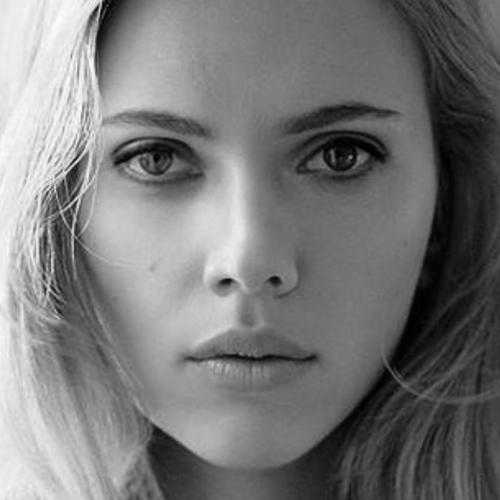

In [12]:
# plot face in dir k
def plot_face(k):
    n = k
    files = [f for f in os.listdir(train_path + str(n)) if os.path.isfile(os.path.join(train_path + str(n), f))]
    i = 3
    imgdis = _Imgdis(filename=train_path + str(n) + '/' + files[i], width=224)
    display(imgdis)

plot_face(6)

Label: 9


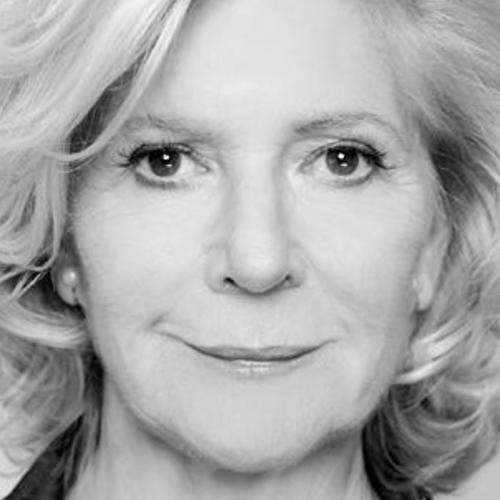

Label: 10


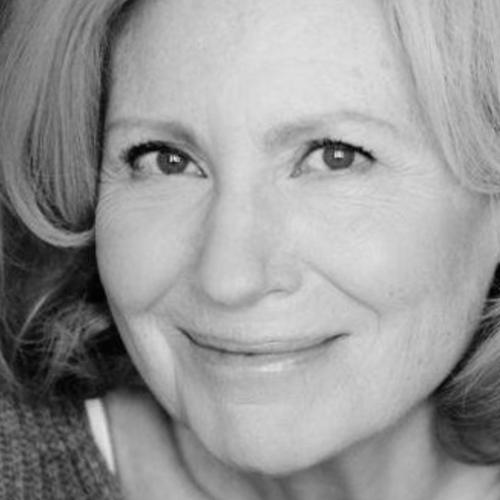

Label: 11


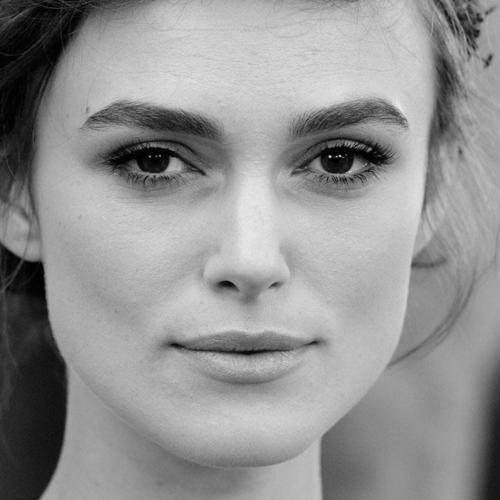

Label: 12


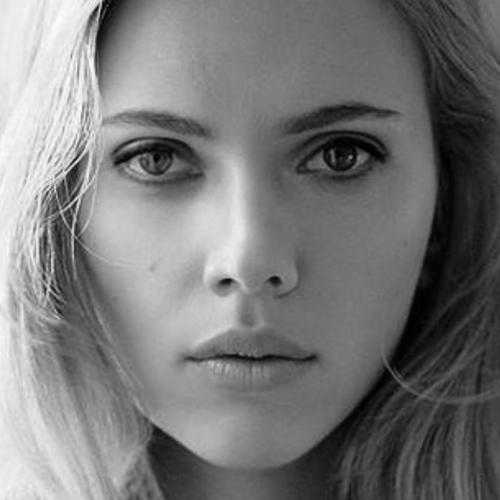

Label: 13


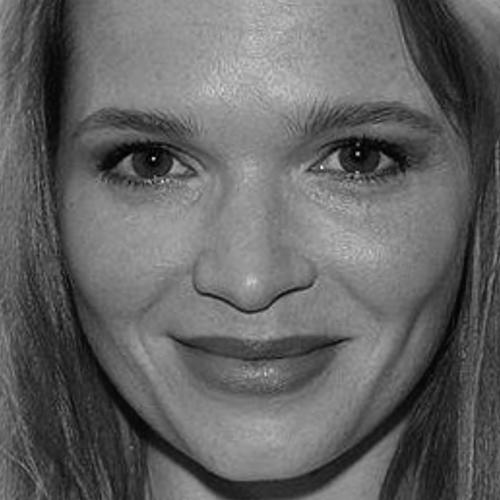

Label: 14


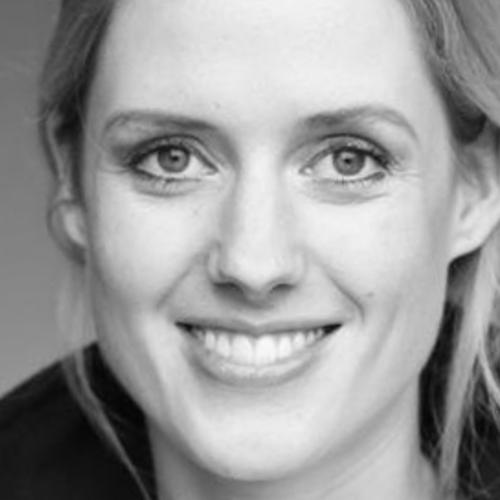

Label: 15


In [14]:
class_labels = train_set.class_indices
class_labels

c = 0
for k, v in class_labels.items():
    c += 1
    if c < 10: continue
    print(f'Label: {v}')
    plot_face(k)

In [46]:
# get images in test set
test_files = []
for f in augtestsplit_set.filenames:
    # replace \\ with /
    f = f.replace('\\', '/')
    test_files.append(f)

test_files

['1/f_o_f_1_1_hshift_-0.25.jpg',
 '1/f_o_f_1_1_hshift_0.25.jpg',
 '1/f_o_f_1_1_noise_3.jpg',
 '1/f_o_f_1_2_bright_1.25.jpg',
 '1/f_o_f_1_2_hshift_-0.125.jpg',
 '1/f_o_f_1_2_rotate_-20.jpg',
 '1/f_o_f_1_2_vshift_-0.125.jpg',
 '1/f_o_f_1_3_hshift_-0.25.jpg',
 '1/f_o_f_1_3_vshift_-0.125.jpg',
 '1/f_o_f_1_4_hshift_-0.25.jpg',
 '1/f_o_f_1_4_hshift_0.25.jpg',
 '1/f_o_f_1_4_rotate_20.jpg',
 '1/f_o_f_1_4_rotate_30.jpg',
 '1/f_o_f_1_4_vshift_-0.25.jpg',
 '1/f_o_f_1_4_vshift_0.125.jpg',
 '1/f_o_f_1_5_noise_3.jpg',
 '1/f_o_f_1_5_rotate_-10.jpg',
 '1/f_o_f_1_5_rotate_10.jpg',
 '1/f_o_f_1_5_rotate_30.jpg',
 '10/m_o_f_2_1_bright_0.75.jpg',
 '10/m_o_f_2_1_bright_1.5.jpg',
 '10/m_o_f_2_1_noise_0.5.jpg',
 '10/m_o_f_2_1_vshift_-0.125.jpg',
 '10/m_o_f_2_1_vshift_0.25.jpg',
 '10/m_o_f_2_2_hshift_-0.125.jpg',
 '10/m_o_f_2_2_hshift_-0.25.jpg',
 '10/m_o_f_2_2_hshift_0.25.jpg',
 '10/m_o_f_2_2_noise_1.jpg',
 '10/m_o_f_2_2_rotate_-10.jpg',
 '10/m_o_f_2_2_rotate_-30.jpg',
 '10/m_o_f_2_2_rotate_20.jpg',
 '10/m_o_

In [63]:
def predict_face(model, i):
    # Load a sample image for prediction
    sample_image_path = f'{augtestsplit_dir}{test_files[i]}'
    sample_image = load_img(sample_image_path, target_size=(224, 224))
    sample_image = img_to_array(sample_image)
    sample_image = np.expand_dims(sample_image, axis=0)
    sample_image = preprocess_input(sample_image)

    # Define regular expression pattern to match the number after the second forward slash
    pattern = r'(?<=/)\d+'
    match = re.search(pattern, sample_image_path)
    number = int(match.group())


    # Make predictions
    predictions = model.predict(sample_image)
    predicted_class = np.argmax(predictions)

    # Get class labels
    class_labels = train_set.class_indices
    class_labels_inv = {v: k for k, v in class_labels.items()}
    print(class_labels[str(number)])

    # Display the predicted class and confidence score
    predicted_label = class_labels_inv[predicted_class]
    confidence_score = predictions[0][predicted_class]

    plt.imshow(sample_image[0].astype(np.uint8))
    plt.title(f"Predicted: {predicted_class}, Confidence: {confidence_score:.2f}")
    plt.axis('off')
    plt.show()

    return predicted_class == class_labels[str(number)]

In [17]:
# print class labels
for k, v in class_labels.items():
    print(k, v)


1 0
10 1
11 2
12 3
13 4
14 5
15 6
16 7
2 8
3 9
4 10
5 11
6 12
7 13
8 14
9 15


## Visualize Predictions of CNN
* trained and tested on normal face images
* If Predicted matches with the nu

1/1 [==============================] - 0s 144ms/step
4


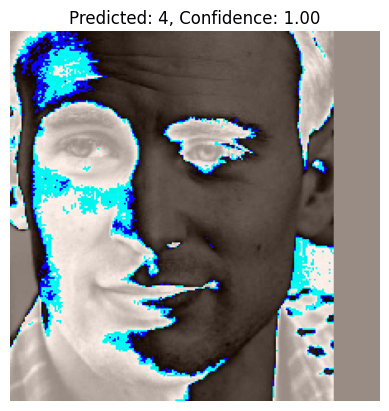

Correct!

1/1 [==============================] - 0s 178ms/step
14


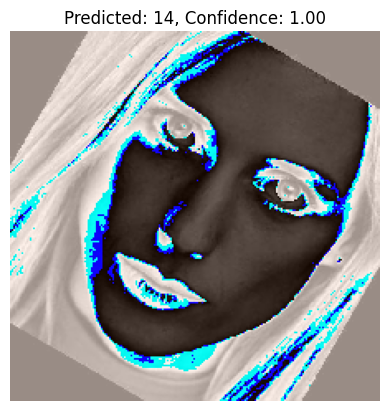

Correct!

1/1 [==============================] - 0s 162ms/step
6


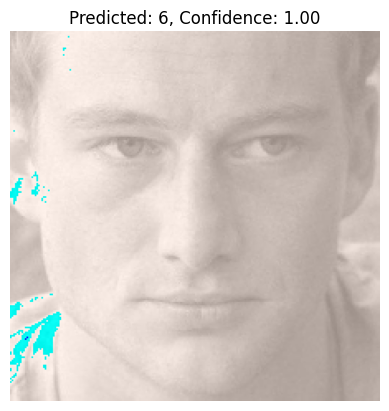

Correct!

1/1 [==============================] - 0s 162ms/step
1


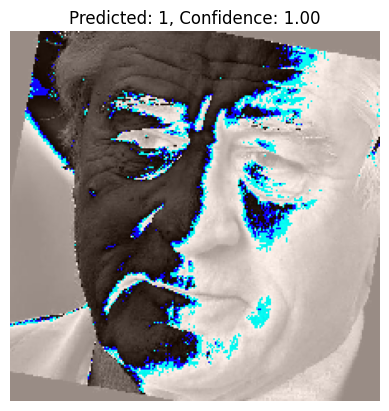

Correct!

1/1 [==============================] - 0s 175ms/step
5


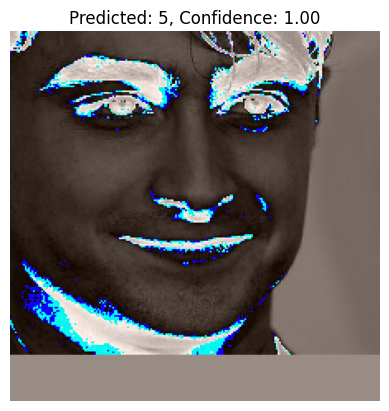

Correct!

1/1 [==============================] - 0s 163ms/step
9


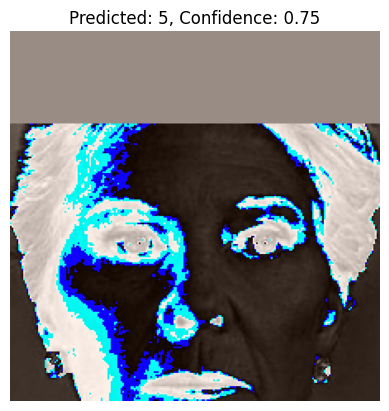

Wrong!

1/1 [==============================] - 0s 173ms/step
3


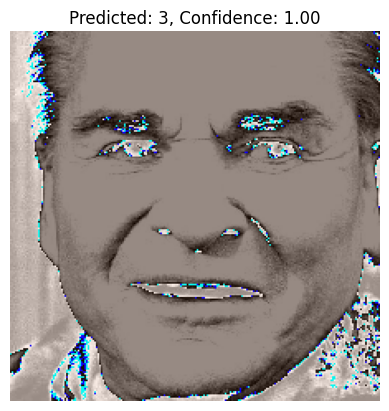

Correct!

1/1 [==============================] - 0s 181ms/step
11


Correct!

1/1 [==============================] - 0s 195ms/step
15


Correct!

1/1 [==============================] - 0s 168ms/step
4


Correct!



In [93]:
# random indices
# randomly split aguaugall into augtrainsplit and augtestsplit
augtrainsplit_dir = os.path.join(data_dir, 'augtrainsplit/')
augtestsplit_dir = os.path.join(data_dir, 'augtestsplit/')

indices = [np.random.randint(0, len(test_files)) for i in range(10)]
for i in indices:
    match = predict_face(model, i)
    if match:
        print("Correct!")
    else:
        print("Wrong!")
    print()

# Base Model (without fine tuning)

In [25]:
adam = optimizers.Adam(learning_rate=0)
base_model = Model(inputs=vgg.input, outputs=prediction)
base_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
base_model.save('base_model.h5')
base_model = load_model('base_model.h5')

1/1 [==============================] - 0s 441ms/step
7


Wrong!

1/1 [==============================] - 0s 158ms/step
4


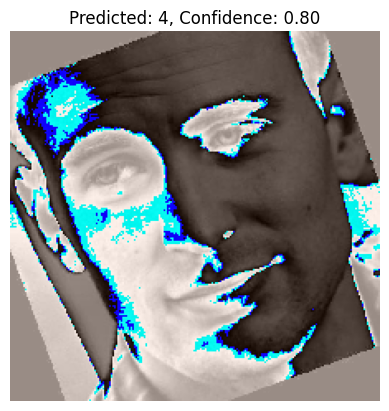

Correct!

1/1 [==============================] - 0s 158ms/step
5


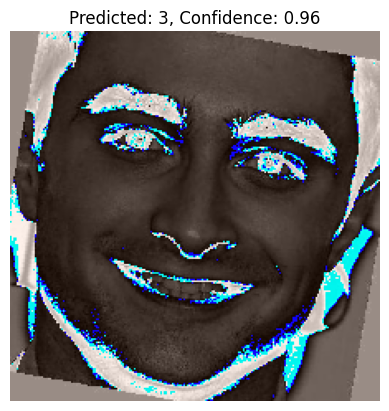

Wrong!

1/1 [==============================] - 0s 175ms/step
6


Wrong!

1/1 [==============================] - 0s 196ms/step
8


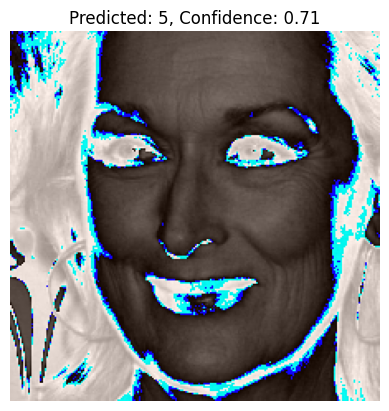

Wrong!

1/1 [==============================] - 0s 165ms/step
7


Wrong!

1/1 [==============================] - 0s 167ms/step
12


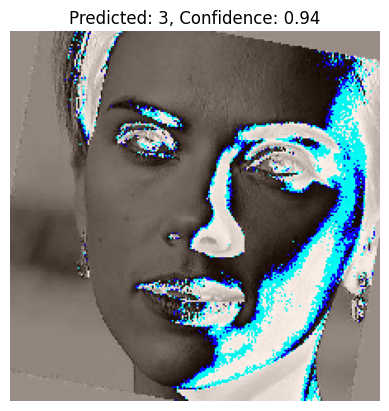

Wrong!

1/1 [==============================] - 0s 199ms/step
3


Wrong!

1/1 [==============================] - 0s 193ms/step
8


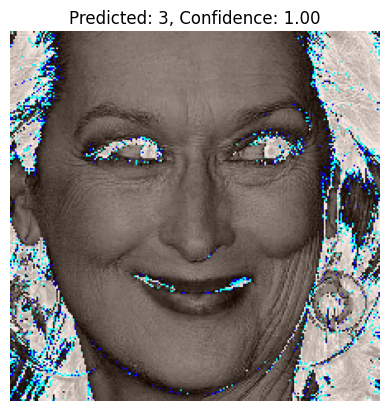

Wrong!

1/1 [==============================] - 0s 174ms/step
1


Wrong!

1/1 [==============================] - 0s 168ms/step
5


Wrong!

1/1 [==============================] - 0s 179ms/step
1


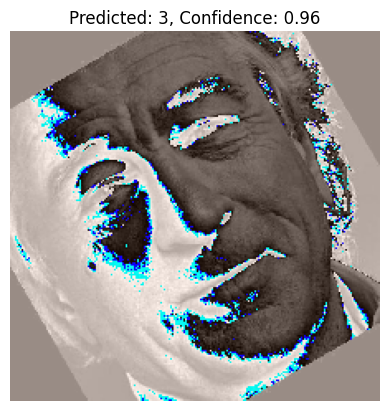

Wrong!

1/1 [==============================] - 0s 167ms/step
8


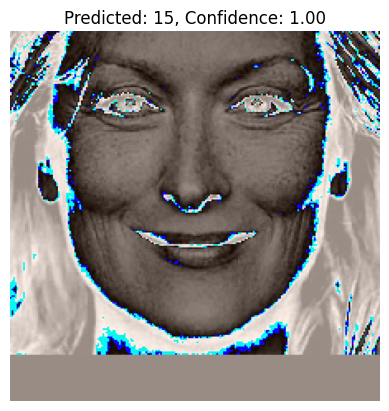

Wrong!

1/1 [==============================] - 0s 168ms/step
13


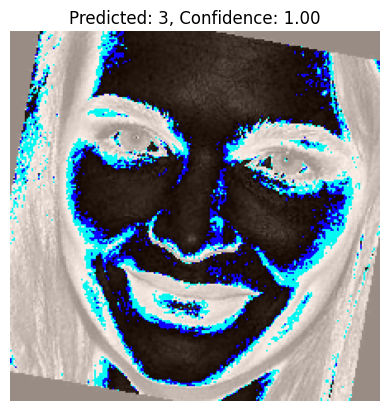

Wrong!

1/1 [==============================] - 0s 208ms/step
14


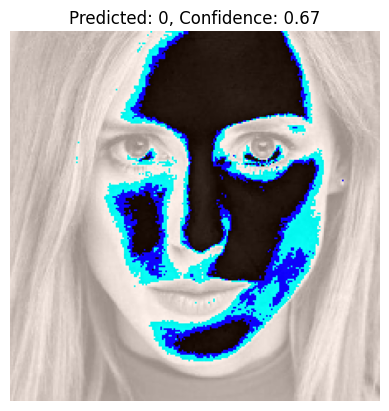

Wrong!

1/1 [==============================] - 0s 175ms/step
14


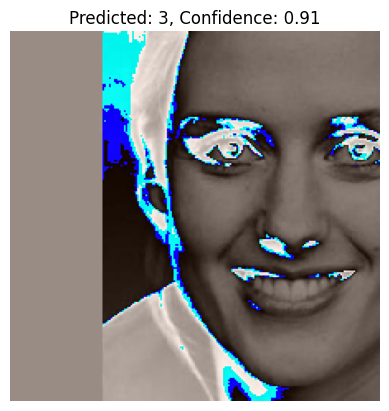

Wrong!

1/1 [==============================] - 0s 177ms/step
6


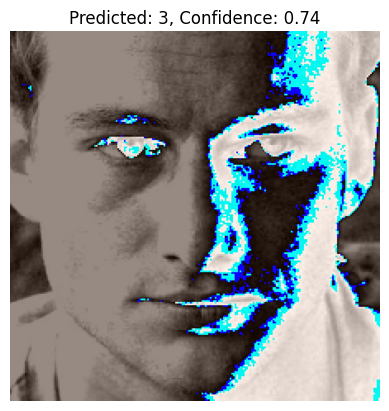

Wrong!

1/1 [==============================] - 0s 168ms/step
14


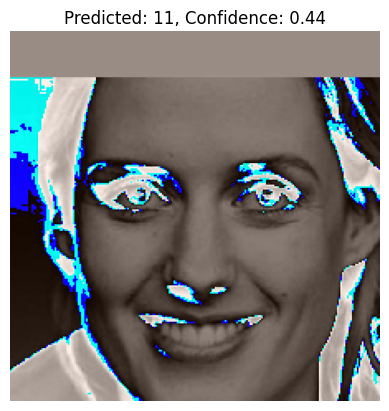

Wrong!

1/1 [==============================] - 0s 195ms/step
11


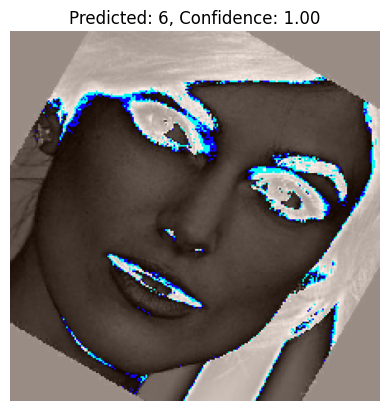

Wrong!

1/1 [==============================] - 0s 171ms/step
6


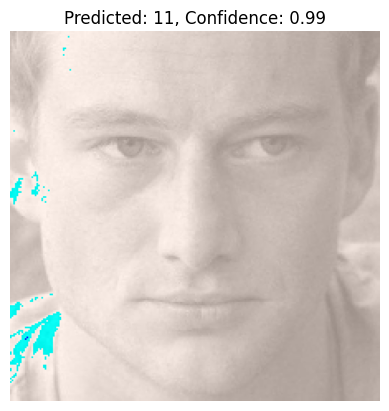

Wrong!

1/1 [==============================] - 0s 219ms/step
12


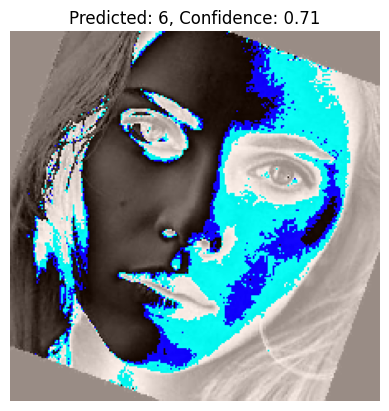

Wrong!

1/1 [==============================] - 0s 192ms/step
1


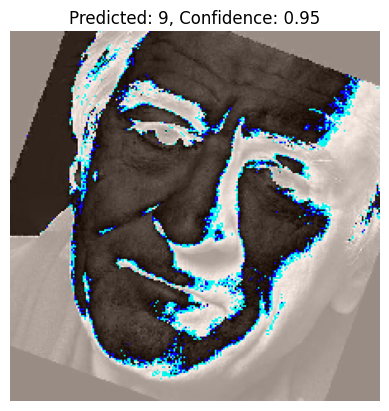

Wrong!

1/1 [==============================] - 0s 206ms/step
0


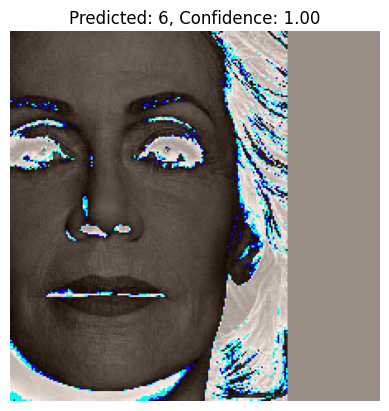

Wrong!

1/1 [==============================] - 0s 166ms/step
12


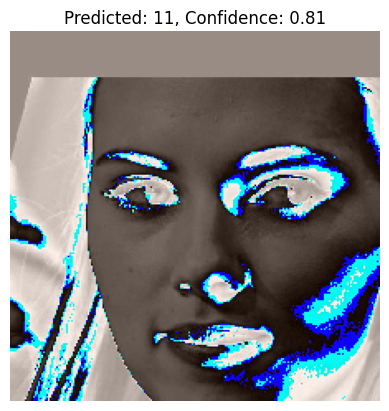

Wrong!

1/1 [==============================] - 0s 224ms/step
12


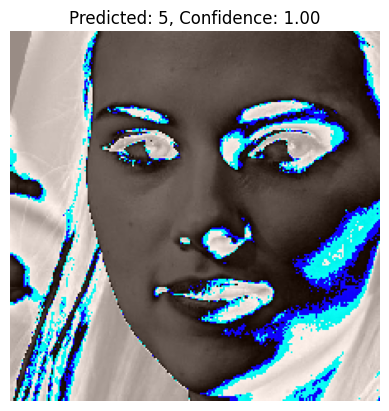

Wrong!

1/1 [==============================] - 0s 176ms/step
3


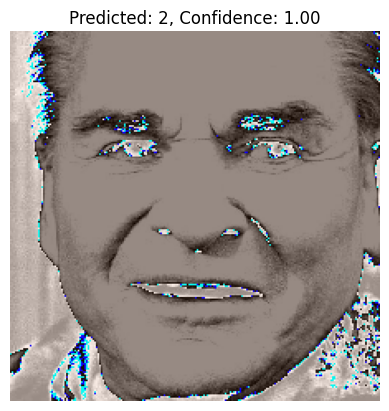

Wrong!

1/1 [==============================] - 0s 201ms/step
5


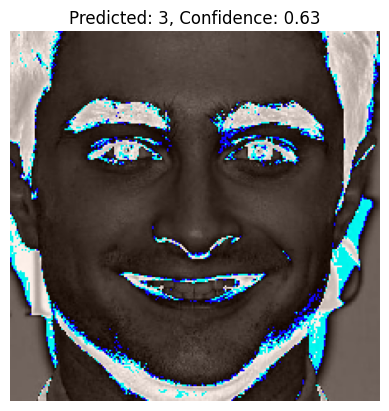

Wrong!

1/1 [==============================] - 0s 208ms/step
12


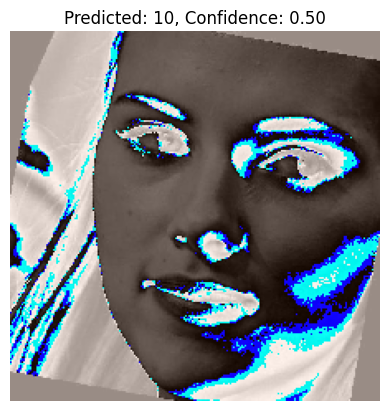

Wrong!

1/1 [==============================] - 0s 210ms/step
7


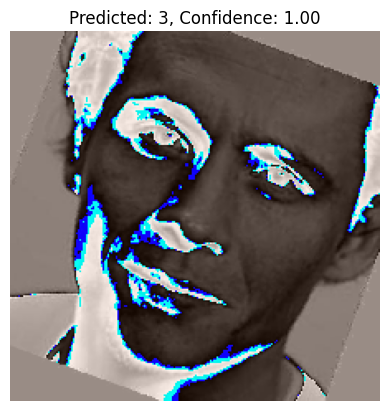

Wrong!

1/1 [==============================] - 0s 221ms/step
5


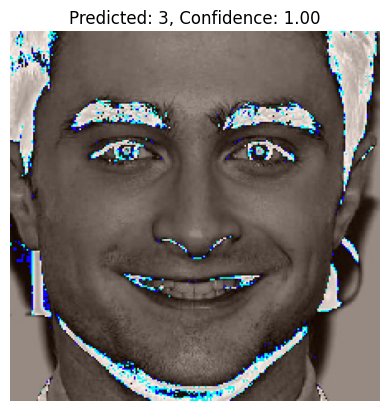

Wrong!

1/1 [==============================] - 0s 190ms/step
2


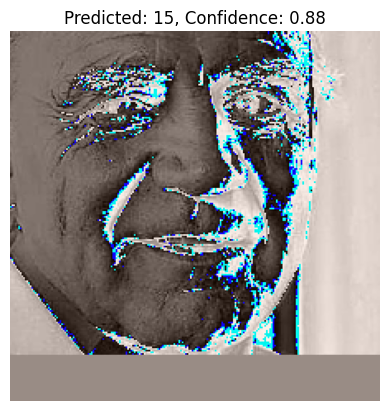

Wrong!

1/1 [==============================] - 0s 208ms/step
2


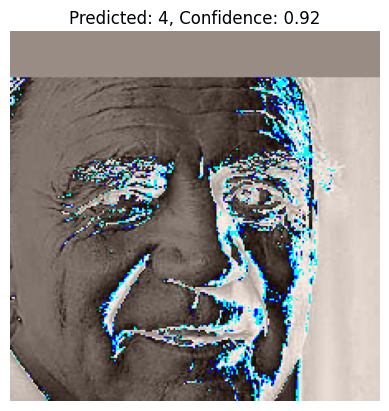

Wrong!

1/1 [==============================] - 0s 184ms/step
3


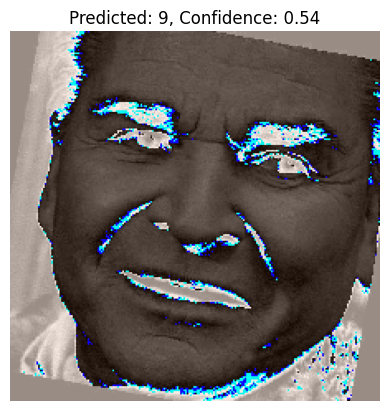

Wrong!

1/1 [==============================] - 0s 203ms/step
14


Wrong!

1/1 [==============================] - 0s 198ms/step
14


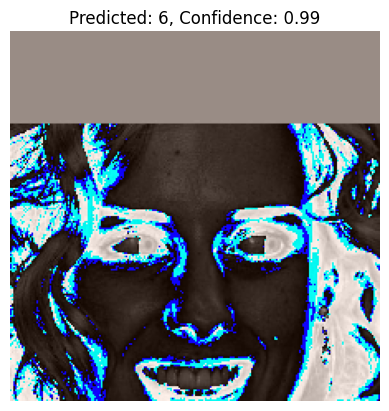

Wrong!

1/1 [==============================] - 0s 197ms/step
3


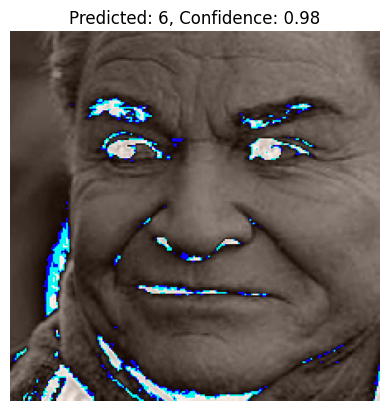

Wrong!

1/1 [==============================] - 0s 193ms/step
11


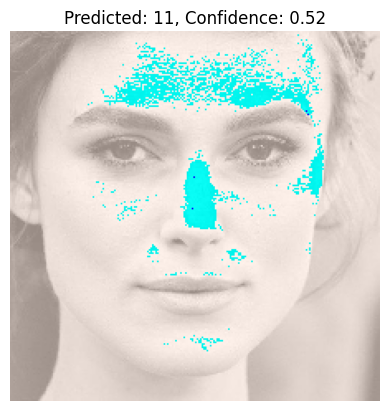

Correct!

1/1 [==============================] - 0s 231ms/step
3


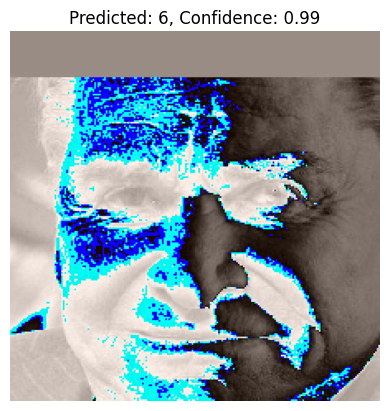

Wrong!

1/1 [==============================] - 0s 214ms/step
3


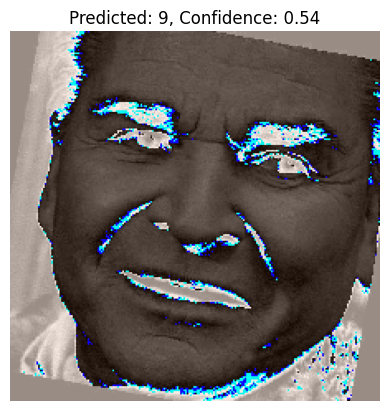

Wrong!

1/1 [==============================] - 0s 243ms/step
14


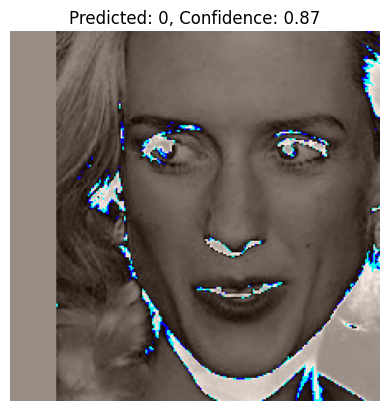

Wrong!

0.05


In [94]:
indices = [np.random.randint(0, len(test_files)) for i in range(40)]
correct = 0
for i in indices:
    match = predict_face(base_model, i)
    if match:
        correct += 1
        print("Correct!")
    else:
        print("Wrong!")
    print()

print(correct / len(indices))

# Dissected CNN

In [74]:
adam = optimizers.Adam(learning_rate=0)
dis_model = Model(inputs=vgg.input, outputs=prediction)
dis_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

metric = 'loss'
checkpoint = ModelCheckpoint(filepath='dis_model.h5', verbose=2, save_best_only=False, monitor=metric)
callbacks = [checkpoint]

In [88]:
exptrain_set = gen.flow_from_directory(
    exptrain_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

exptest_set = gen.flow_from_directory(
    exptest_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 1408 images belonging to 16 classes.
Found 352 images belonging to 16 classes.


In [89]:
dis_model.fit(
    exptrain_set,
    validation_data=test_set,
    epochs=20,
    steps_per_epoch=3,
    validation_steps=5,
    callbacks=callbacks,
)

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 6.5659 - accuracy: 0.6354
Epoch 1: saving model to dis_model.h5
3/3 [==============================] - 11s 4s/step - loss: 6.5659 - accuracy: 0.6354
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 6.8965 - accuracy: 0.6354
Epoch 2: saving model to dis_model.h5
3/3 [==============================] - 10s 3s/step - loss: 6.8965 - accuracy: 0.6354
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 8.6583 - accuracy: 0.5312
Epoch 3: saving model to dis_model.h5
3/3 [==============================] - 10s 3s/step - loss: 8.6583 - accuracy: 0.5312
Epoch 4/20
3/3 [==============================] - ETA: 0s - loss: 6.3471 - accuracy: 0.6354
Epoch 4: saving model to dis_model.h5
3/3 [==============================] - 10s 3s/step - loss: 6.3471 - accuracy: 0.6354
Epoch 5/20
3/3 [==============================] - ETA: 0s - loss: 9.4266 - accuracy: 0.4688
Epoch 5: saving model to dis_model.h5
3/3 [=====

In [90]:
# save model
# dis_model.save('dis_model.h5')
dis_model = load_model('dis_model.h5')